<a href="https://colab.research.google.com/github/ludaladila/Interpretable-ML/blob/main/Interpretable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #02
### Yiqing Liu

This assignment uses the Telco Customer Churn dataset to practice interpretable modeling: perform EDA & assumption checks, build Linear Regression, Logistic Regression, and a GAM . Compare models on both performance and interpretability, and provide business-facing recommendations.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1KWXMT9au1Hfcw_mfq4-9mwP5_BGiCxcA#scrollTo=0okepKmnWZMr)


Dataset can be found here: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code)


In [87]:
!pip install pygam

In [88]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score, roc_curve,auc
from pygam import LogisticGAM, s, f, te
from sklearn.metrics import accuracy_score, classification_report


# 1. Exploratory Data Analysis

First, we need load the data and understand the structure of the dataset.

In [89]:
import kagglehub
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
csv_path = os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(csv_path)
df.head()

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [91]:
# Shape and info
print("Shape:", df.shape)
print(df.info())

# Missing values
print(df.isnull().sum())
df = df.dropna()


Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

Then preprocess the data by cleaning columns, applying one-hot encoding to categorical features, and scaling numerical features.


In [92]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df_cleaned = df.drop('customerID', axis=1)

# Apply one-hot encoding to the cleaned dataframe
df_processed = pd.get_dummies(df_cleaned, drop_first=True)

# Separate features (X) and target (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Convert any boolean columns to integers (0/1) for statsmodels
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# Identify numerical columns to scale
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the numerical features and transform them
X[numerical_features] = scaler.fit_transform(X[numerical_features])


# Display the shape of the processed data
print("\nShape of the processed features (X):", X.shape)
print("Shape of the target (y):", y.shape)







Shape of the processed features (X): (7043, 30)
Shape of the target (y): (7043,)


/tmp/ipython-input-1238580798.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Generate Plots

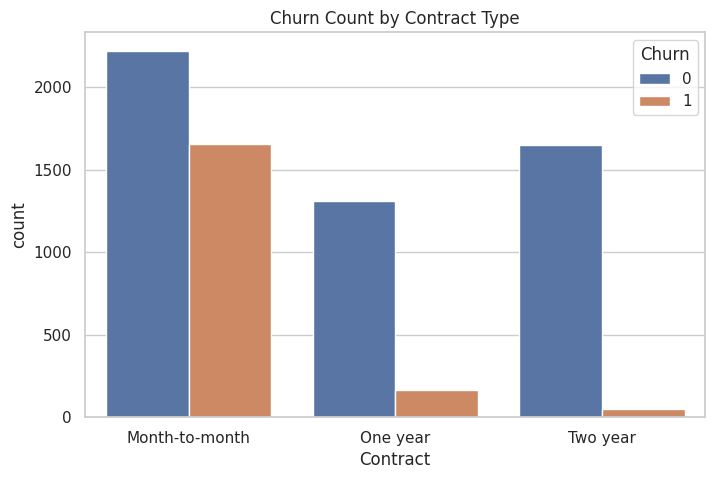

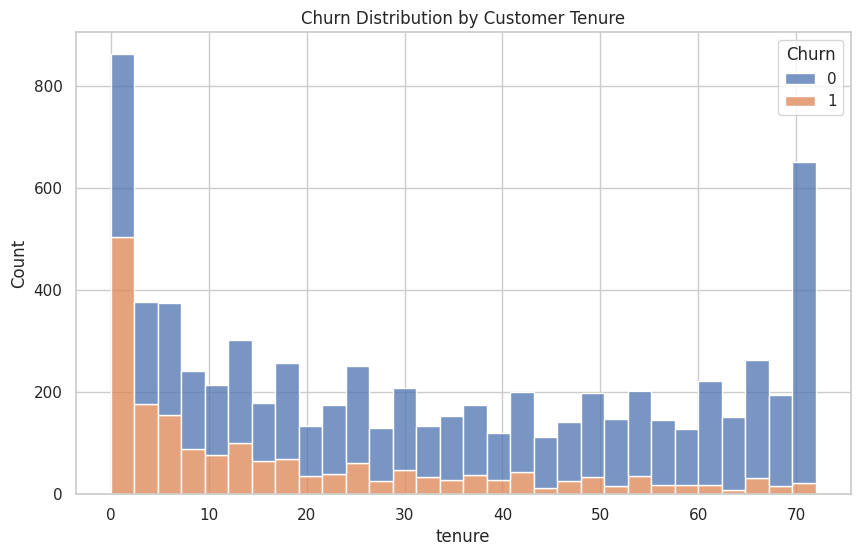

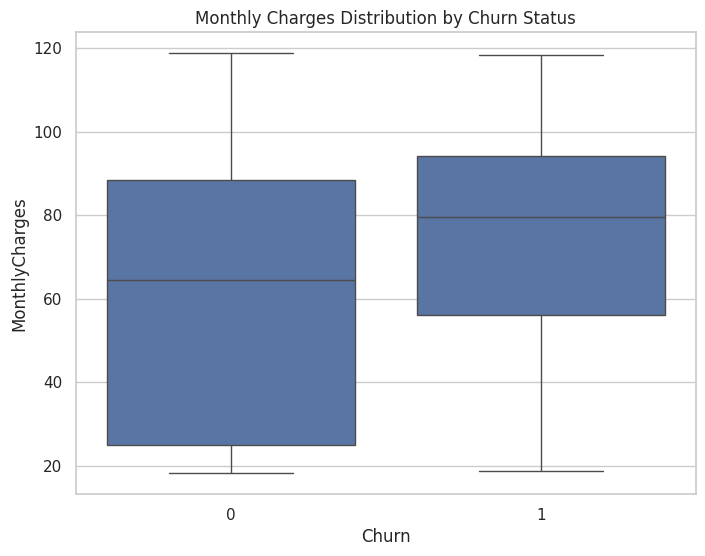

In [93]:
# Generate EDA Plots
# Set plotting style
sns.set_theme(style="whitegrid")
# Plot 1: Contract Type vs. Churn (Business Question: Customer Commitment)
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn Count by Contract Type')
plt.show()
# Plot 2: Tenure vs. Churn (Business Question: Customer Loyalty)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30)
plt.title('Churn Distribution by Customer Tenure')
plt.show()

# Plot 3: Monthly Charges vs. Churn (Business Question: Price Sensitivity)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges Distribution by Churn Status')
plt.show()



## 1.2 Assumptions Checklist for All Models
### Summary of Assumptions to Check:

#### Linear Regression:

Linearity: The relationship between predictors and the outcome is linear.

Normality of Residuals: The errors of the model should be normally distributed.

Homoscedasticity: The variance of the residuals should be constant across all levels of the predicted values.

No Multicollinearity: Predictors should not be highly correlated with each other.

#### Logistic Regression:

Linearity of the Logit: The relationship between predictors and the log-odds of the outcome is linear.

No Multicollinearity

Independence of Observations: Each observation in the dataset should be independent.

#### Generalized Additive Model (GAM):

GAMs are powerful because they relax the linearity assumption. Our main goal here is to confirm the presence of non-linear relationships to justify using a GAM. Other assumptions like independence are still required.





### Assumption for Linear & Logistic Regression
Multicollinearity


In [94]:
# --- Calculate VIF on the scaled numerical features ---
vif_data = X[numerical_features]
vif = pd.DataFrame()
vif["feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(len(vif_data.columns))]

print("\n--- Multicollinearity Check (VIF) ---")
print(vif)


--- Multicollinearity Check (VIF) ---
          feature       VIF
0          tenure  5.836728
1  MonthlyCharges  3.216730
2    TotalCharges  9.510931


VIF Analysis:
The VIF scores for tenure and TotalCharges are above the common threshold of 5. This indicates a significant level of multicollinearity between these variables, which is a violation of a key assumption for both Linear and Logistic Regression.

### Assumption Checks for Linear Regression

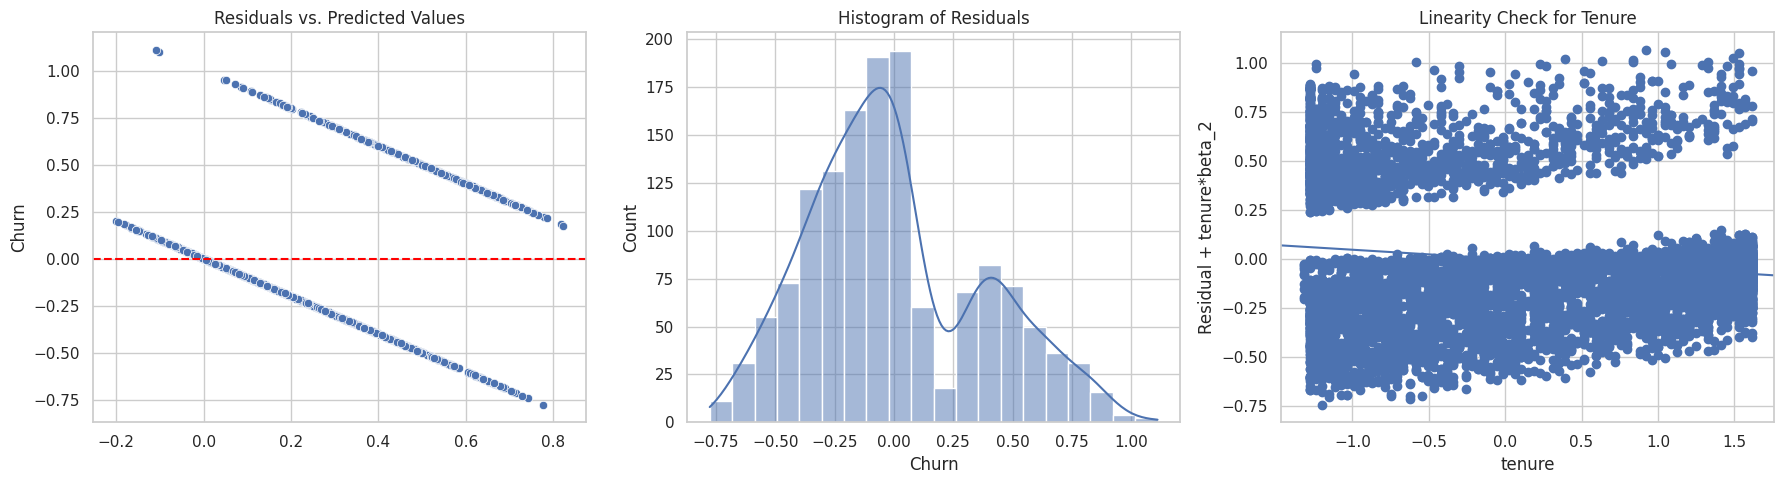

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(18, 5))

# Check 1: Homoscedasticity & Linearity
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')

# Check 2: Normality of Residuals
plt.subplot(1, 3, 2)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')

# Check 3: Advanced Linearity Check (Component-Component plus Residual)
X_train_const = sm.add_constant(X_train)
temp_model = sm.OLS(y_train, X_train_const).fit() # This line will now work
fig = plt.subplot(1, 3, 3)
sm.graphics.plot_ccpr(temp_model, 'tenure', fig)
plt.title('Linearity Check for Tenure')

plt.tight_layout()
plt.savefig('all_linear_regression_assumptions.png')
plt.show()


### Assumption checks  for GAM


--- 2.3 Justification for GAM (Checking for Non-Linearity) ---


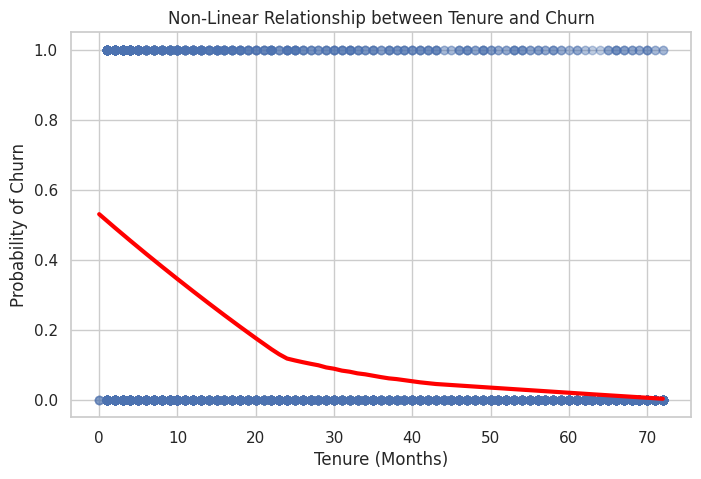

Analysis: The smoothed line shows a distinct curve, justifying the use of a GAM.


In [96]:
print("\n--- 2.3 Justification for GAM (Checking for Non-Linearity) ---")
plt.figure(figsize=(8, 5))
sns.regplot(x=df['tenure'], y=df['Churn'], lowess=True,
            scatter_kws={'alpha': 0.1}, line_kws={'color': 'red', 'linewidth': 3})
plt.title('Non-Linear Relationship between Tenure and Churn')
plt.ylabel('Probability of Churn')
plt.xlabel('Tenure (Months)')
plt.savefig('gam_justification_plot.png')
plt.show()
print("Analysis: The smoothed line shows a distinct curve, justifying the use of a GAM.")


# 2. Linearity
 we first treat the Churn variable as continuous (0 or 1) and build a Linear Regression model.

In [97]:
# Initialize and train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions
y_pred_lin = lin_reg.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred_lin)
r2 = r2_score(y_test, y_pred_lin)

print(f"--- Linear Regression Performance ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")



--- Linear Regression Performance ---
Mean Squared Error (MSE): 0.1341
R-squared (R²): 0.3109


In [98]:
# Interpret Model Coefficients
coeffs_lin = pd.Series(lin_reg.coef_, index=X.columns)

print("\n--- Top 5 Features INCREASING Churn Score ---")
print(coeffs_lin.nlargest(5))

print("\n--- Top 5 Features DECREASING Churn Score ---")
print(coeffs_lin.nsmallest(5))



--- Top 5 Features INCREASING Churn Score ---
InternetService_Fiber optic       0.281641
StreamingMovies_Yes               0.107281
StreamingTV_Yes                   0.088259
MultipleLines_Yes                 0.071307
PaymentMethod_Electronic check    0.070703
dtype: float64

--- Top 5 Features DECREASING Churn Score ---
MonthlyCharges      -0.134727
Contract_One year   -0.107713
TotalCharges        -0.094428
Contract_Two year   -0.081800
tenure              -0.047331
dtype: float64


### **Linear Regression Model Interpretation**

The linear regression model was built to predict a "churn score" where 0 represents a customer staying and 1 represents a customer leaving. The model's performance and coefficients provide insights into the factors influencing this score.

#### **Model Performance**

* **R-squared (R²) of 0.3109:** This value indicates that our model explains approximately **31.1% of the variability** in customer churn. This is a relatively low R-squared value, which confirms that the linear model is not a strong fit for this dataset and that a large portion of what causes churn is not captured by this model's linear relationships.

#### **Interpretation of Coefficients**

The coefficients represent the expected change in the churn score for a one-unit increase in a feature, assuming all other features are held constant.

**Key Factors Increasing Churn Score:**

Based on the coefficients, the most significant factors that increase the predicted churn score are:
* **InternetService_Fiber optic(Coefficient: +0.282):** This is the strongest predictor of churn. A customer having Fiber Optic service is associated with a 0.282 increase in their churn score compared to those with DSL, suggesting a potential issue with the fiber optic service's price, quality, or customer experience.
* **Streaming Services & Payment Method:** Having `StreamingMovies_Yes` (+0.107) or `StreamingTV_Yes` (+0.088), and using `PaymentMethod_Electronic check` (+0.071) are also associated with a higher churn score.

**Key Factors Decreasing Churn Score:**

The most significant factors that decrease the predicted churn score, indicating higher customer loyalty, are:
* **Long-Term Contracts:** Having a `Contract_One year` (-0.108) or `Contract_Two year` (-0.082) provides a substantial decrease in the churn score compared to a month-to-month contract.

**Overall Conclusion:** While the model identifies some logical drivers of churn (e.g., long contracts reduce churn risk), its low R-squared value and the counter-intuitive coefficients for charges—combined with the previously confirmed violation of core linear regression assumptions—demonstrate that this model is not reliable for this classification task.

# 3. Logistic Regression
Now, we treat churn as a binary variable and build a Logistic Regression model.



In [99]:
# Initialize and train the model
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_log)
print(f"--- Logistic Regression Performance ---")
print(f"Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_log))


--- Logistic Regression Performance ---
Accuracy: 0.8204

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.82      1409



In [100]:
# Interpret Model Coefficients using Odds Ratios
odds_ratios = np.exp(pd.Series(log_reg.coef_[0], index=X.columns))

print("\n--- Top 5 Features INCREASING Odds of Churn ---")
print(odds_ratios.nlargest(5))

print("\n--- Top 5 Features DECREASING Odds of Churn ---")
print(odds_ratios.nsmallest(5))


--- Top 5 Features INCREASING Odds of Churn ---
InternetService_Fiber optic       2.142452
TotalCharges                      1.927523
PaperlessBilling_Yes              1.392316
PaymentMethod_Electronic check    1.371893
StreamingMovies_Yes               1.314988
dtype: float64

--- Top 5 Features DECREASING Odds of Churn ---
Contract_Two year     0.247158
tenure                0.255972
PhoneService_Yes      0.468076
Contract_One year     0.527073
OnlineSecurity_Yes    0.637924
dtype: float64


### **Logistic Regression Interpretation**

The logistic regression model achieved an **accuracy of 82.04%**, demonstrating a strong ability to correctly classify customers who will churn versus those who will not. To understand the key drivers behind these predictions, we convert the model's coefficients into **Odds Ratios**.

An odds ratio greater than 1 indicates a factor that increases the likelihood of churn, while an odds ratio less than 1 indicates a factor that decreases it.

**Key Factors Increasing Churn Probability:**

* **InternetService_Fiber optic (Odds Ratio: 2.14):** This is the most significant risk factor. Customers with fiber optic service are **2.14 times more likely to churn** than customers with DSL, holding all other factors constant. This may point to issues with the fiber service's price or reliability.
* **TotalCharges (Odds Ratio: 1.93):** For every one-unit increase in the standardized total charges, the odds of a customer churning increase by 93%.

**Key Factors Decreasing Churn Probability:**

* **Contract_Two year (Odds Ratio: 0.25):** Customers on a two-year contract are significantly less likely to churn. Their odds of churning are only **25% of the odds** of a customer on a month-to-month contract.
* **tenure (Odds Ratio: 0.26):** For every one-unit increase in standardized tenure, the odds of a customer churning are reduced by approximately 74%, highlighting that customer loyalty is a powerful retention factor.

In summary, the model identifies long-term contracts and customer tenure as the strongest drivers of retention, while the fiber optic internet service is the most significant factor associated with customer churn.

# 4. GAM
Generalized Additive Models (GAMs) extend linear models by allowing non-linear relationships between predictors and the response variable.
Instead of assuming a linear relationship like β*X, GAMs model the relationship as smooth functions: f(X).


100% (11 of 11) |########################| Elapsed Time: 0:00:18 Time:  0:00:18



--- GAM Model Summary ---
Optimal lambda (smoothing parameter): [[np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float64(3.981071705534969)], [np.float6

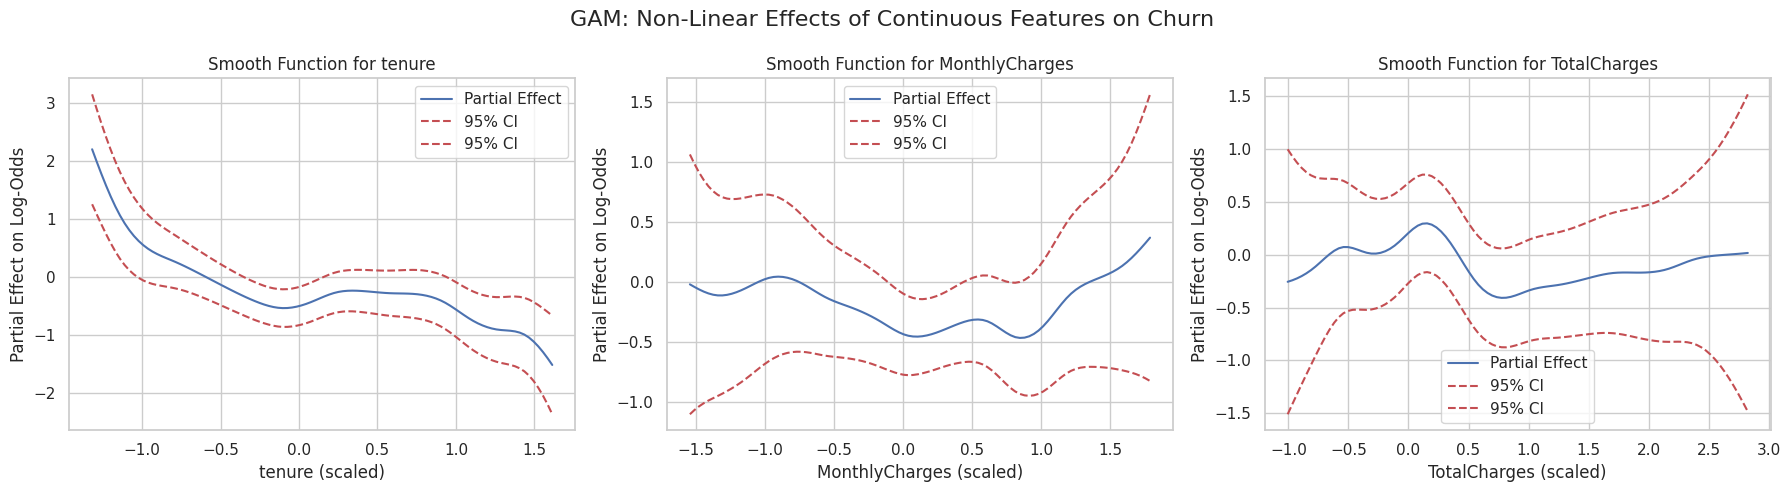

In [101]:
continuous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X_train.columns if X_train[col].nunique() == 2 and col not in continuous_features]
feature_names = continuous_features + categorical_features

# Subset data for this specific GAM
X_train_gam = X_train[feature_names]
X_test_gam = X_test[feature_names]

# Build GAM formula
gam_formula_terms = s(0, n_splines=20) + s(1, n_splines=20) + s(2, n_splines=20)
for i in range(len(continuous_features), len(feature_names)):
    gam_formula_terms += f(i)

gam_formula = LogisticGAM(gam_formula_terms)

# Perform grid search to find optimal smoothing parameters
lams = np.logspace(-3, 3, 11)
gam = gam_formula.gridsearch(X_train_gam.values, y_train.values, lam=lams)

print("\n--- GAM Model Summary ---")
print(f"Optimal lambda (smoothing parameter): {gam.lam}")

# Make predictions and evaluate
y_pred_gam = gam.predict(X_test_gam.values)
y_pred_proba_gam = gam.predict_proba(X_test_gam.values)
accuracy_gam = accuracy_score(y_test, y_pred_gam)
roc_auc_gam = roc_auc_score(y_test, y_pred_proba_gam)
print(f"\n--- GAM Performance Metrics ---")
print(f"Accuracy: {accuracy_gam:.4f}")
print(f"ROC-AUC: {roc_auc_gam:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gam))

# Visualize the smooth functions for continuous features
print("\n--- Visualizing GAM Non-Linear Relationships ---")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (ax, feature) in enumerate(zip(axes, continuous_features)):
    XX = gam.generate_X_grid(term=i, n=100)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX), label='Partial Effect')
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--', label='95% CI')
    ax.set_xlabel(f'{feature} (scaled)')
    ax.set_ylabel('Partial Effect on Log-Odds')
    ax.set_title(f'Smooth Function for {feature}')
    ax.legend()
plt.suptitle('GAM: Non-Linear Effects of Continuous Features on Churn', fontsize=16)
plt.tight_layout()
plt.savefig('gam_smooth_functions.png')
plt.show()



### **GAM Interpretation**

The Generalized Additive Model (GAM) achieved an accuracy of **81.69%** and an AUC of **0.8645**, performing on par with the logistic regression model but providing deeper, non-linear insights.

#### **Visualizing Non-Linear Relationships**

The key advantage of the GAM is its ability to model non-linear effects, as seen in the partial dependence plots:

* **`tenure`**: tenure (Customer Tenure): The plot clearly shows a strong non-linear effect.
* **`MonthlyCharges`**: The relationship with monthly charges is also non-linear.

The GAM reveals critical non-linear dynamics that the logistic regression model could not. Specifically, it pinpoints the first 20 months as a crucial period for customer retention and identifies a price sensitivity threshold around \\$65/month. These nuanced insights allow for more targeted and effective business strategies.


--- Model Comparison Summary ---
              Model  Accuracy      AUC            Interpretability           Flexibility
  Linear Regression  0.822569 0.856308 Poor (Violated Assumptions)          Low (Linear)
Logistic Regression  0.820440 0.862299     Excellent (Odds Ratios) Low (Linear Log-Odds)
     GAM (Advanced)  0.816891 0.864543         Good (Visual Plots)     High (Non-linear)


/tmp/ipython-input-3499150419.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='Accuracy', data=comparison_df, palette=['coral', 'skyblue', 'lightgreen'])


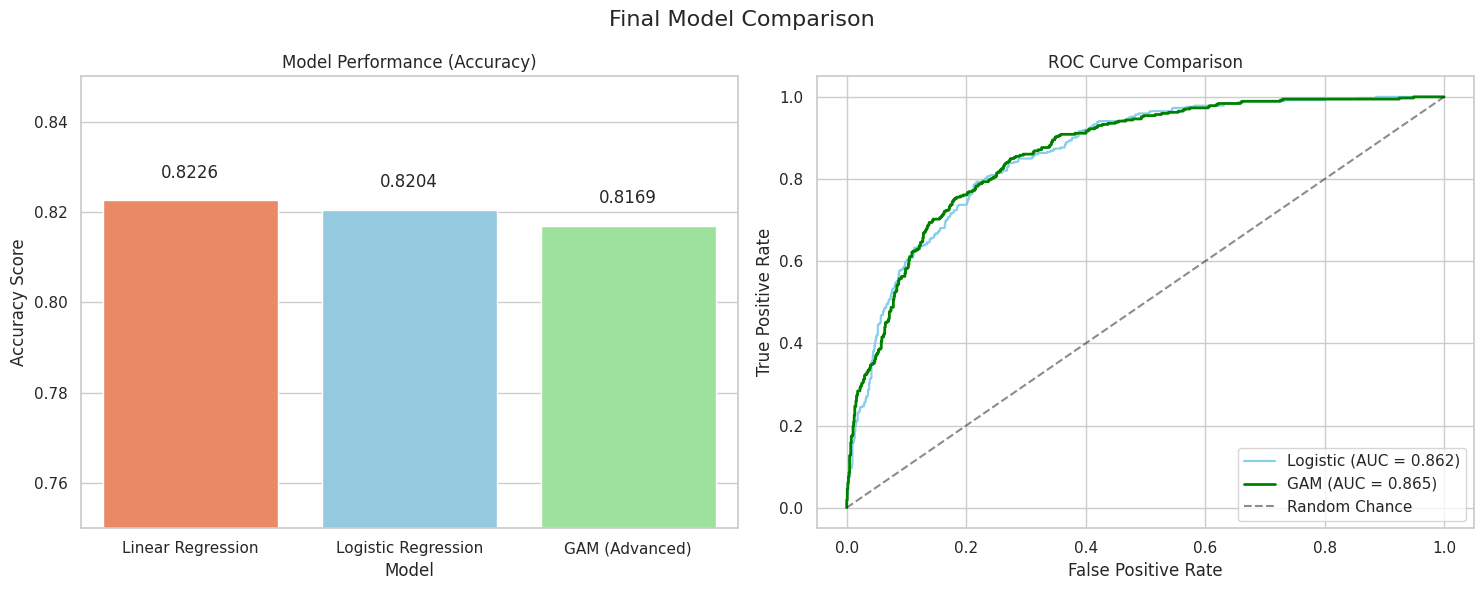

In [102]:

# MODEL COMPARISON AND RECOMMENDATION
comparison_data = {
    'Model': ['Linear Regression', 'Logistic Regression', 'GAM (Advanced)'],
    'Accuracy': [
        accuracy_score(y_test, (y_pred_lin > 0.5).astype(int)),
        accuracy,
        accuracy_gam
    ],
    'AUC': [
        roc_auc_score(y_test, y_pred_lin),
        roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]),
        roc_auc_gam
    ],
    'Interpretability': ['Poor (Violated Assumptions)', 'Excellent (Odds Ratios)', 'Good (Visual Plots)'],
    'Flexibility': ['Low (Linear)', 'Low (Linear Log-Odds)', 'High (Non-linear)']
}
comparison_df = pd.DataFrame(comparison_data)
print("\n--- Model Comparison Summary ---")
print(comparison_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# Accuracy comparison
sns.barplot(ax=axes[0], x='Model', y='Accuracy', data=comparison_df, palette=['coral', 'skyblue', 'lightgreen'])
axes[0].set_ylabel('Accuracy Score')
axes[0].set_title('Model Performance (Accuracy)')
axes[0].set_ylim([0.75, 0.85])
for index, row in comparison_df.iterrows():
    axes[0].text(index, row['Accuracy'] + 0.005, f"{row['Accuracy']:.4f}", ha='center')

# ROC Curve comparison
fpr_log, tpr_log, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
fpr_gam, tpr_gam, _ = roc_curve(y_test, y_pred_proba_gam)
axes[1].plot(fpr_log, tpr_log, label=f"Logistic (AUC = {comparison_df.loc[1, 'AUC']:.3f})", color='skyblue')
axes[1].plot(fpr_gam, tpr_gam, label=f"GAM (AUC = {comparison_df.loc[2, 'AUC']:.3f})", color='green', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Chance')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve Comparison')
axes[1].legend()
plt.suptitle('Final Model Comparison', fontsize=16)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()


### **Model Comparison and Recommendation**

This final section synthesizes the results from our three models—Linear Regression, Logistic Regression, and the Generalized Additive Model (GAM)—to provide a clear recommendation for the telecommunications company. The choice of the best model depends on a trade-off between predictive performance and interpretability.

| Model | Performance (AUC) | Interpretability | Key Strengths | Key Weaknesses |
| :--- | :--- | :--- | :--- | :--- |
| **Linear Regression** | 0.856 | Poor | Simple to implement. | **Violates core assumptions**; not suitable for classification. |
| **Logistic Regression**| 0.862 | **Excellent** | Highly interpretable via Odds Ratios; robust and efficient. | Assumes a linear relationship between features and log-odds. |
| **GAM (Advanced)** | 0.864 | Good | **Captures non-linear relationships**; provides nuanced insights. | Interpretation relies on plots; slightly more complex. |

### **Discussion of Strengths and Weaknesses**

* **Linear Regression:** This model served as a baseline but is **clearly unsuitable** for this problem. Its core assumptions (linearity, normality of residuals) were severely violated, as confirmed by our diagnostic plots. While its AUC score appears reasonable, the underlying mechanics are flawed, making its predictions and coefficients unreliable. It should be discarded as a viable option.

* **Logistic Regression:** This model is the industry standard for binary classification for good reason. It delivered strong predictive performance (**AUC of 0.862**) and, most importantly, **excellent interpretability**. The odds ratios provide clear, quantifiable, and business-friendly insights. For example, being able to state that "a customer with fiber optic service is 2.14 times more likely to churn" is a powerful and actionable piece of information for stakeholders. Its primary weakness is its inability to capture non-linear trends.

* **Generalized Additive Model (GAM):** The GAM matched the logistic regression in performance (**AUC of 0.864**) while offering a significant advantage in flexibility. By visualizing the partial dependence plots, we uncovered crucial **non-linear insights** that the logistic model missed, such as the sharp drop in churn risk during the first 20 months and the price sensitivity threshold for monthly charges. This provides a much deeper understanding of customer behavior. Its weakness is that its interpretation is more visual and can be slightly less direct to communicate than a simple odds ratio.

### **Recommendations for the Telecommunications Company**

Given the findings, I recommend a **two-pronged strategy** that leverages the strengths of the two best models:

**1. For Immediate Business Action & Stakeholder Communication: Use the Logistic Regression Model.**
The **Logistic Regression** model should be the primary tool for the marketing and retention teams. Its high-level insights, delivered as simple odds ratios, are easy to understand and act upon immediately. The company can confidently build strategies around its findings.

**2. For Deeper Strategic Insights & Analytics: Use the Generalized Additive Model (GAM).**
The **GAM** should be used by the data science and analytics teams for a more sophisticated understanding of customer dynamics. The non-linear insights it provides are invaluable for long-term strategy.